In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from helpers import util
import os

In [2]:
today = datetime.now(timezone.utc).replace(tzinfo=None)
today

datetime.datetime(2025, 11, 17, 13, 44, 37, 80454)

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-17 14:44:37,086 INFO: Initializing external client
2025-11-17 14:44:37,087 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 14:44:37,597 WARNING: UserWarning: The installed hopsworks client version 4.1.4 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 14:44:38,398 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272018


In [4]:
mr = project.get_model_registry()

models = ["base", "lagged"]

retrieved_model = {}
saved_model_dir = {}

for model in models:
    retrieved_model[model] = mr.get_model(
        name=f"air_quality_xgboost_{model}_model",
        version=1,
    )
    # Download the saved models artifacts to a local directory
    saved_model_dir[model] = retrieved_model[model].download()

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

retrieved_xgboost_models = {}

for model in models:
    retrieved_xgboost_models[model] = XGBRegressor()
    retrieved_xgboost_models[model].load_model(saved_model_dir[model] + "/model.json")

In [6]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

yesterday_2359 = (today - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)
air_quality_data = air_quality_fg.filter(air_quality_fg.date >= yesterday_2359.date()).read().drop(columns="url")
weather_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by='date')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.57s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.56s) 


In [7]:
weather_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,0.50,0.0,0.720000,180.000000,skoghall
1,2025-11-18 00:00:00+00:00,0.30,0.0,1.800000,360.000000,jonsbyn
2,2025-11-18 00:00:00+00:00,0.35,0.0,1.138420,108.435043,nykroppa
3,2025-11-18 00:00:00+00:00,0.35,0.0,2.620839,344.054535,årjäng
4,2025-11-19 00:00:00+00:00,-1.60,0.0,10.028439,21.037588,årjäng
5,2025-11-19 00:00:00+00:00,-1.20,0.1,2.811690,50.194473,jonsbyn
6,2025-11-19 00:00:00+00:00,-0.90,0.2,5.351785,47.726372,skoghall
7,2025-11-19 00:00:00+00:00,-1.65,0.0,5.815978,68.198532,nykroppa
10,2025-11-20 00:00:00+00:00,-3.05,0.0,6.162207,353.290253,skoghall
11,2025-11-20 00:00:00+00:00,-2.95,0.0,9.422101,6.581848,årjäng


In [8]:
air_quality_data

,date,pm25,lagged_1,lagged_2,lagged_3,country,city,street
0,2025-11-17 00:00:00+00:00,3.0,2.0,2.0,2.0,sweden,årjäng,strand
1,2025-11-17 00:00:00+00:00,3.0,11.0,5.0,3.0,sweden,skoghall,folkungavägen
2,2025-11-17 00:00:00+00:00,1.0,3.0,2.0,1.0,sweden,jonsbyn,acksjön
3,2025-11-17 00:00:00+00:00,3.0,4.0,7.0,2.0,sweden,nykroppa,timmersvägen


In [9]:
def prepare_prediction_row(row, air_quality_data, lagged_available):
    # Ensure air_quality_data['date'] is datetime
    air_quality_data['date'] = pd.to_datetime(air_quality_data['date'])
    
    # Initialize dictionary for features
    features = {}
    city = row['city']
    pred_date = pd.to_datetime(row['date'])
    prev_date = pred_date - pd.Timedelta(days=1)

    # filter the air quality data
    last_days_aq = air_quality_data[
        (air_quality_data['city'] == city) &
        (air_quality_data['date'].dt.date == prev_date.date())
    ]

    if lagged_available:
        features['lagged_3'] = last_days_aq['lagged_2'].item()
        features['lagged_2'] = last_days_aq['lagged_1'].item()
        features['lagged_1'] = last_days_aq['predicted_pm25'].item()
    features['city'] = city
    features['street'] = last_days_aq['street'].item()
    features['country'] = last_days_aq['country'].item()
    features['date'] = pred_date
    
    # Copy weather features
    weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    for col in weather_cols:
        features[col] = row[col]
    
    # Convert to single-row DataFrame
    prediction_df = pd.DataFrame([features])
    prediction_df['city'] = prediction_df['city'].astype('category')
    
    return prediction_df

In [10]:
def append_predicted_pm25(air_quality_data, prediction_row, predicted_pm25, lagged_available):
    new_row = prediction_row
    new_row["predicted_pm25"] = predicted_pm25
    if lagged_available:
        new_row['lagged_1'] = prediction_row['lagged_1']
        new_row['lagged_2'] = prediction_row['lagged_2']
        new_row['lagged_3'] = prediction_row['lagged_3']
    
    # Append new row to DataFrame
    updated_air_quality_data = pd.concat([air_quality_data, pd.DataFrame(new_row)], ignore_index=True)
    return updated_air_quality_data

In [11]:
lagged_available = {}
lagged_available['base'] = False
lagged_available['lagged'] = True
prediction_features = {}
prediction_features['base'] = ['city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
prediction_features['lagged'] = ['lagged_1', 'lagged_2', 'lagged_3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast = {}
air_quality_forecast['base'] = air_quality_data.copy().drop(columns=['lagged_1', 'lagged_2', 'lagged_3']).rename(columns={"pm25": "predicted_pm25"})
air_quality_forecast['lagged'] = air_quality_data.copy().rename(columns={"pm25": "predicted_pm25"})

for _, prediction in weather_data.iterrows():
    pred_date = pd.to_datetime(prediction['date'])
    prediction_df = {}
    predicted_pm25 = {}
    for model in models:
        prediction_df[model] = prepare_prediction_row(prediction, air_quality_forecast[model], lagged_available[model])
        predicted_pm25[model] = retrieved_xgboost_models[model].predict(prediction_df[model][prediction_features[model]])
        air_quality_forecast[model] = append_predicted_pm25(air_quality_forecast[model], prediction_df[model], predicted_pm25[model], lagged_available=lagged_available[model])

In [12]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
for model in models:
    air_quality_forecast[model][weather_cols] = air_quality_forecast[model][weather_cols].astype('float32')
    air_quality_forecast[model]['date'] = pd.to_datetime(air_quality_forecast[model]['date']).dt.tz_convert(None)
    air_quality_forecast[model]['days_before_forecast_day'] = (air_quality_forecast[model]['date'] - pd.Timestamp(today).normalize()).dt.days
    air_quality_forecast[model] = air_quality_forecast[model][air_quality_forecast[model]['days_before_forecast_day'] > 0]

air_quality_forecast['base']

,date,predicted_pm25,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-18,34.620789,sweden,skoghall,folkungavägen,0.50,0.0,0.720000,180.000000,1
5,2025-11-18,12.898911,sweden,jonsbyn,acksjön,0.30,0.0,1.800000,360.000000,1
6,2025-11-18,19.246237,sweden,nykroppa,timmersvägen,0.35,0.0,1.138420,108.435043,1
7,2025-11-18,13.790023,sweden,årjäng,strand,0.35,0.0,2.620839,344.054535,1
8,2025-11-19,2.788301,sweden,årjäng,strand,-1.60,0.0,10.028439,21.037588,2
9,2025-11-19,18.420986,sweden,jonsbyn,acksjön,-1.20,0.1,2.811690,50.194473,2
10,2025-11-19,19.422417,sweden,skoghall,folkungavägen,-0.90,0.2,5.351785,47.726372,2
11,2025-11-19,17.248121,sweden,nykroppa,timmersvägen,-1.65,0.0,5.815978,68.198532,2
12,2025-11-20,15.119712,sweden,skoghall,folkungavägen,-3.05,0.0,6.162207,353.290253,3
13,2025-11-20,10.164616,sweden,årjäng,strand,-2.95,0.0,9.422101,6.581848,3


In [13]:
air_quality_forecast['lagged']

,date,predicted_pm25,lagged_1,lagged_2,lagged_3,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-18,6.518769,3.000000,11.000000,5.000000,sweden,skoghall,folkungavägen,0.50,0.0,0.720000,180.000000,1
5,2025-11-18,3.317907,1.000000,3.000000,2.000000,sweden,jonsbyn,acksjön,0.30,0.0,1.800000,360.000000,1
6,2025-11-18,6.427220,3.000000,4.000000,7.000000,sweden,nykroppa,timmersvägen,0.35,0.0,1.138420,108.435043,1
7,2025-11-18,6.082072,3.000000,2.000000,2.000000,sweden,årjäng,strand,0.35,0.0,2.620839,344.054535,1
8,2025-11-19,7.610998,6.082072,3.000000,2.000000,sweden,årjäng,strand,-1.60,0.0,10.028439,21.037588,2
9,2025-11-19,5.407851,3.317907,1.000000,3.000000,sweden,jonsbyn,acksjön,-1.20,0.1,2.811690,50.194473,2
10,2025-11-19,13.830637,6.518769,3.000000,11.000000,sweden,skoghall,folkungavägen,-0.90,0.2,5.351785,47.726372,2
11,2025-11-19,10.395617,6.427220,3.000000,4.000000,sweden,nykroppa,timmersvägen,-1.65,0.0,5.815978,68.198532,2
12,2025-11-20,10.150412,13.830637,6.518769,3.000000,sweden,skoghall,folkungavägen,-3.05,0.0,6.162207,353.290253,3
13,2025-11-20,8.681726,7.610998,6.082072,3.000000,sweden,årjäng,strand,-2.95,0.0,9.422101,6.581848,3


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
docs_folder = "docs"
if not os.path.exists(docs_folder):
    os.mkdir(docs_folder)
    
base_folder = docs_folder + "/air_quality"
if not os.path.exists(base_folder):
    os.mkdir(base_folder)

model_dir = {}
images_dir = {}

for model in models:
    model_dir[model] = base_folder + f"/{model}"
    if not os.path.exists(model_dir[model]):
        os.mkdir(model_dir[model])
    images_dir[model] = model_dir[model] + '/images'
    if not os.path.exists(images_dir[model]):
        os.mkdir(images_dir[model])

In [15]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

2025-11-17 14:44:52,909 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



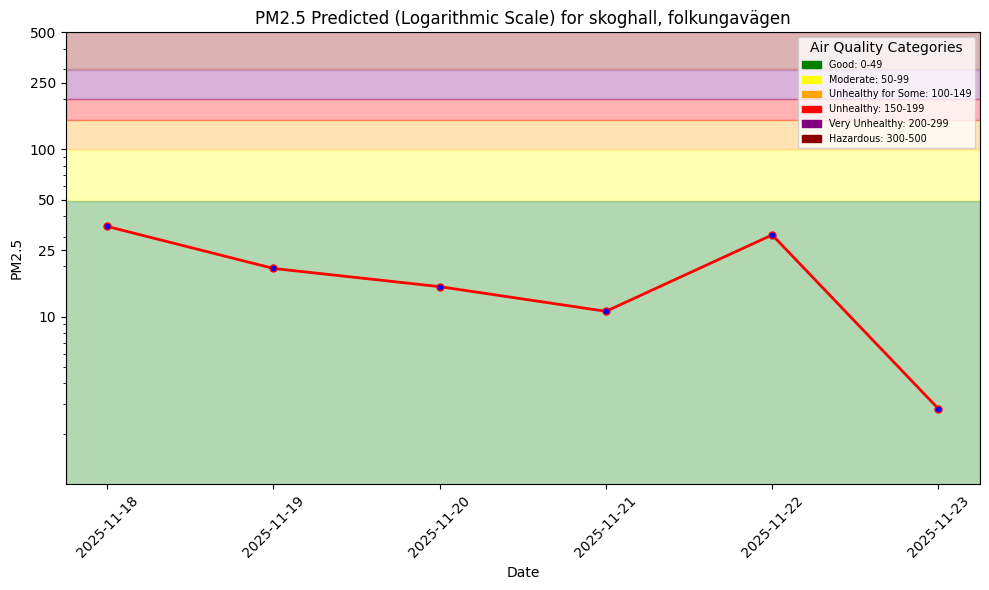

Uploading: 0.000%|          | 0/51966 elapsed<00:00 remaining<?

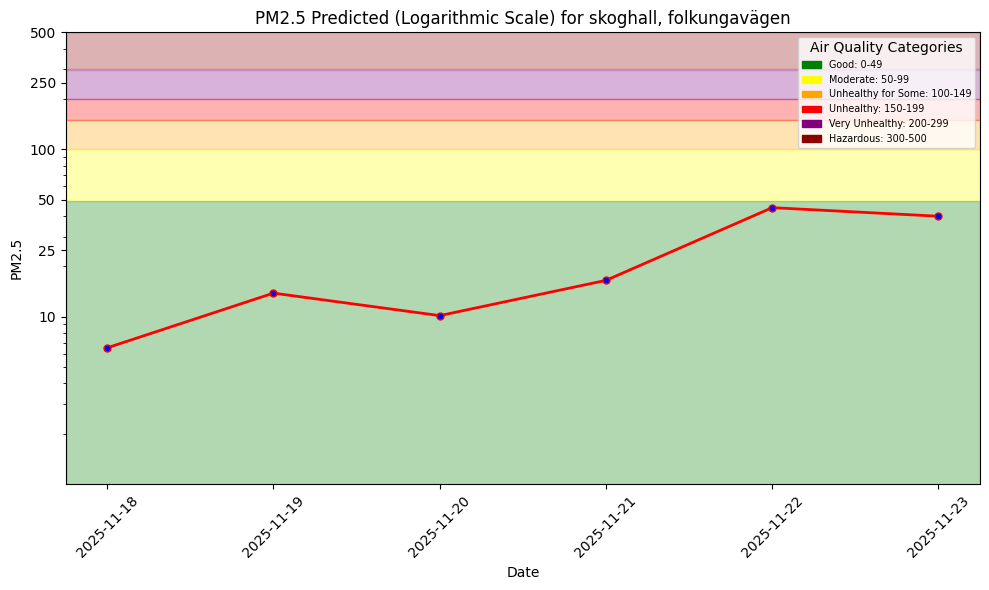

Uploading: 0.000%|          | 0/47762 elapsed<00:00 remaining<?

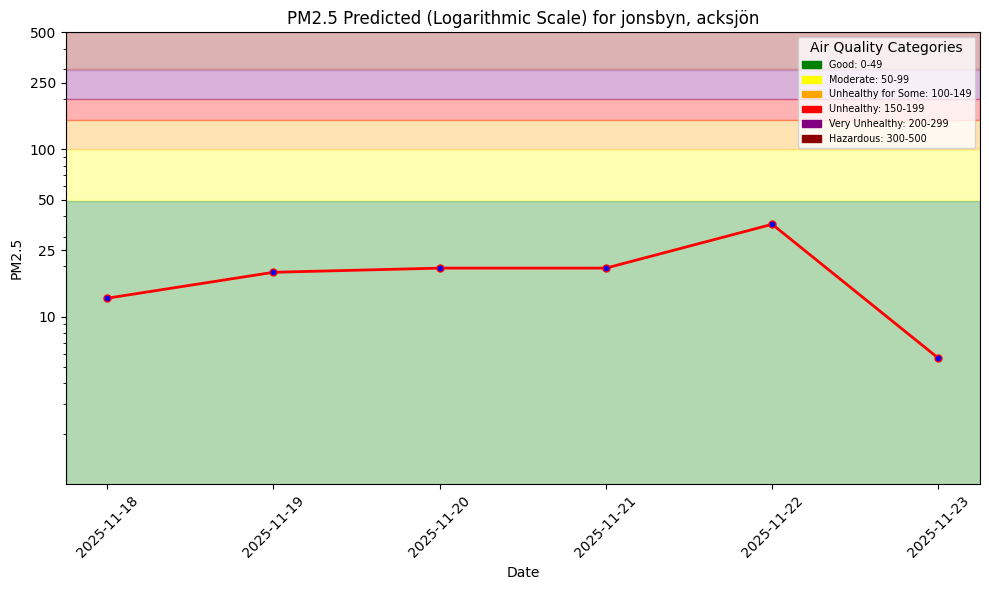

Uploading: 0.000%|          | 0/47254 elapsed<00:00 remaining<?

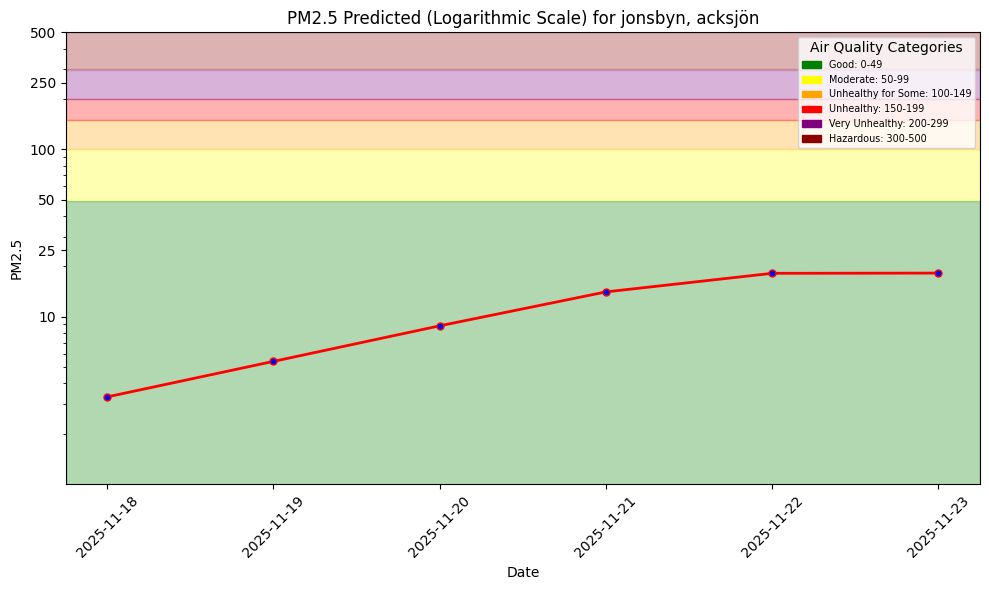

Uploading: 0.000%|          | 0/45446 elapsed<00:00 remaining<?

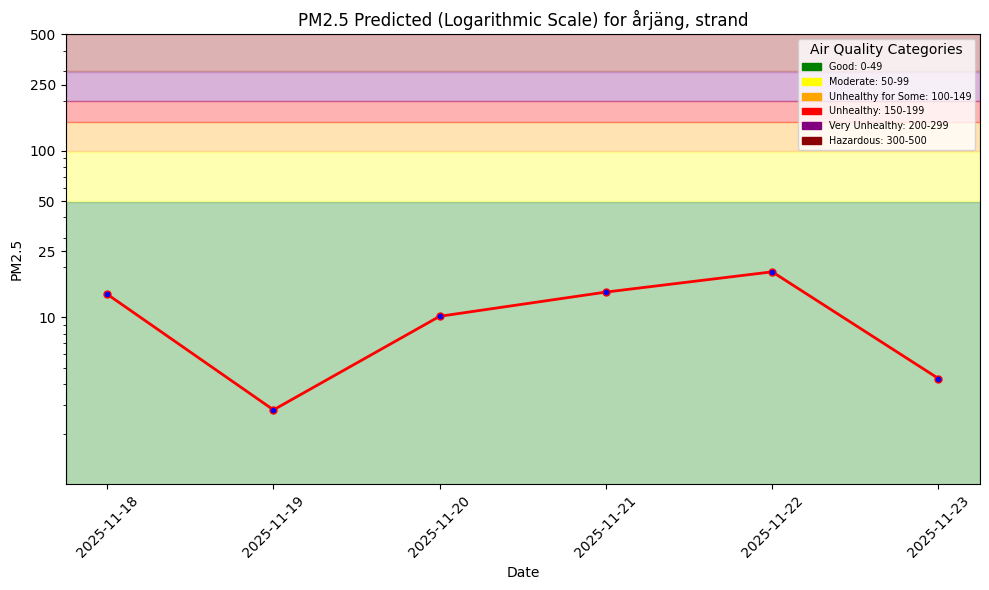

Uploading: 0.000%|          | 0/50826 elapsed<00:00 remaining<?

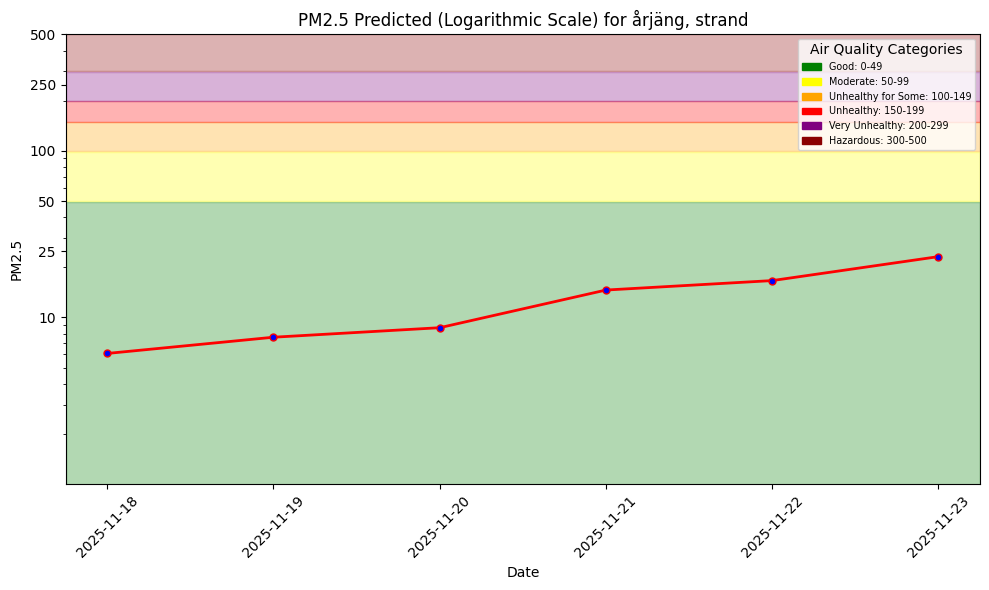

Uploading: 0.000%|          | 0/43877 elapsed<00:00 remaining<?

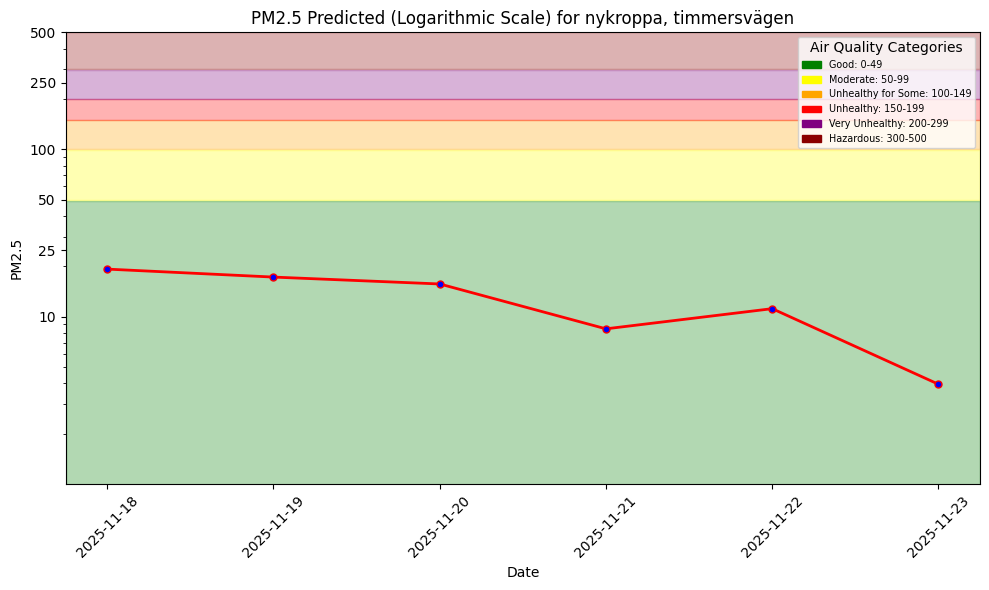

Uploading: 0.000%|          | 0/46907 elapsed<00:00 remaining<?

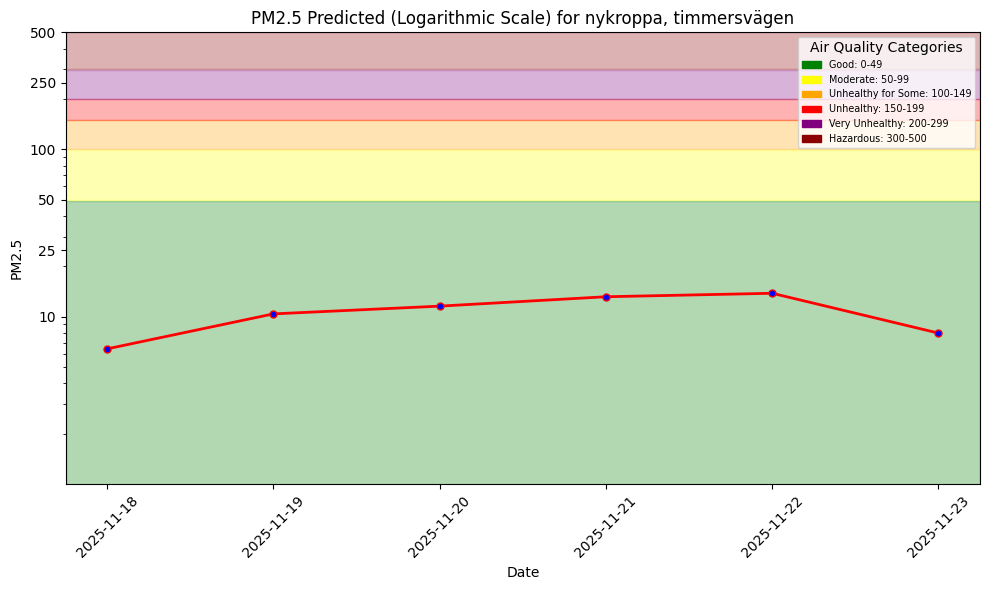

Uploading: 0.000%|          | 0/46180 elapsed<00:00 remaining<?

In [16]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    city_dir = {}
    file_path = {}
    plots = {}
    for model in models:
        city_dir[model] = f"{images_dir[model]}/{city}"
        if not os.path.exists(city_dir[model]):
            os.mkdir(city_dir[model])
        file_path[model] = f"{city_dir[model]}/pm25_forecast.png"
        plots[model] = util.plot_air_quality_forecast(city, street, air_quality_forecast[model][air_quality_forecast[model]['city'] == city], file_path[model])
        plots[model].show()
        dataset_api.upload(file_path[model], f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

In [17]:
monitor_fg = {}

for model in models:
    monitor_fg[model] = fs.get_or_create_feature_group(
        name=f'aq_predictions_{model}',
        description=f'Air Quality prediction monitoring ({model})',
        version=1,
        primary_key=['city','street','country','days_before_forecast_day'],
        event_time="date"
    )
    monitor_fg[model].insert(air_quality_forecast[model], wait=True)


Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_base_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272018/jobs/named/aq_predictions_base_1_offline_fg_materialization/executions
2025-11-17 14:45:30,809 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 14:45:34,042 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 14:47:07,404 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 14:47:07,551 INFO: Waiting for log aggregation to finish.
2025-11-17 14:47:16,165 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272018/jobs/named/aq_predictions_lagged_1_offline_fg_materialization/executions
2025-11-17 14:47:33,395 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-17 14:47:36,623 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 14:49:06,982 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 14:49:07,148 INFO: Waiting for log aggregation to finish.
2025-11-17 14:49:15,790 INFO: Execution finished successfully.


In [18]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring = {}

for model in models:
    monitoring[model] = monitor_fg[model].filter(monitor_fg[model].days_before_forecast_day == 1).read()

air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.79s) 


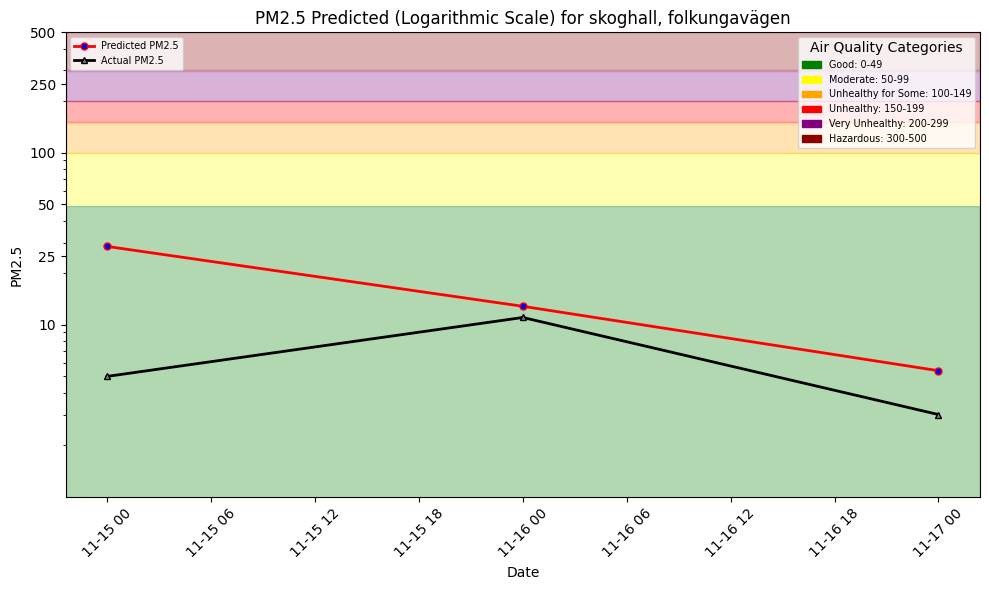

Uploading: 0.000%|          | 0/58605 elapsed<00:00 remaining<?

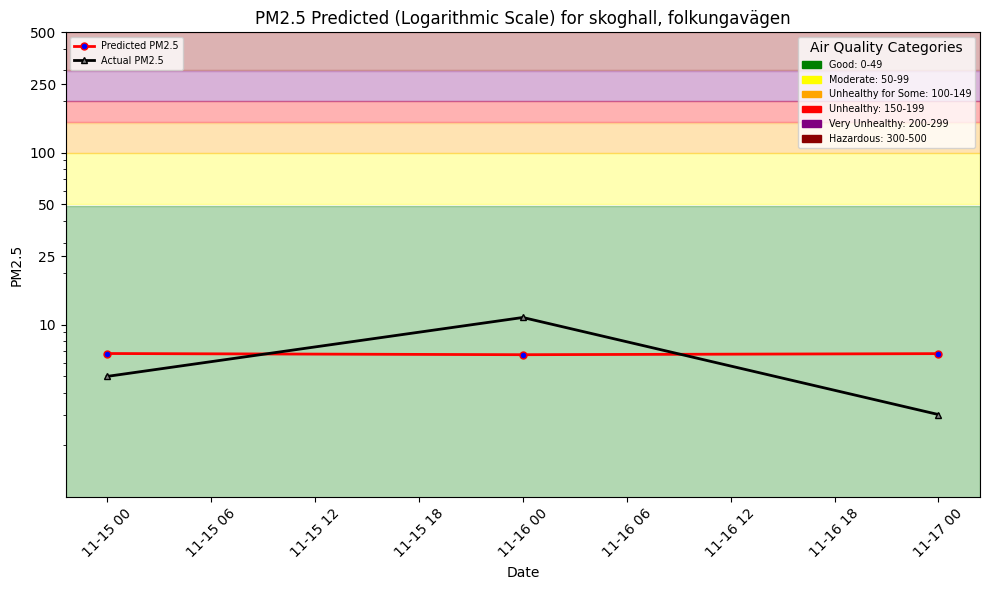

Uploading: 0.000%|          | 0/53177 elapsed<00:00 remaining<?

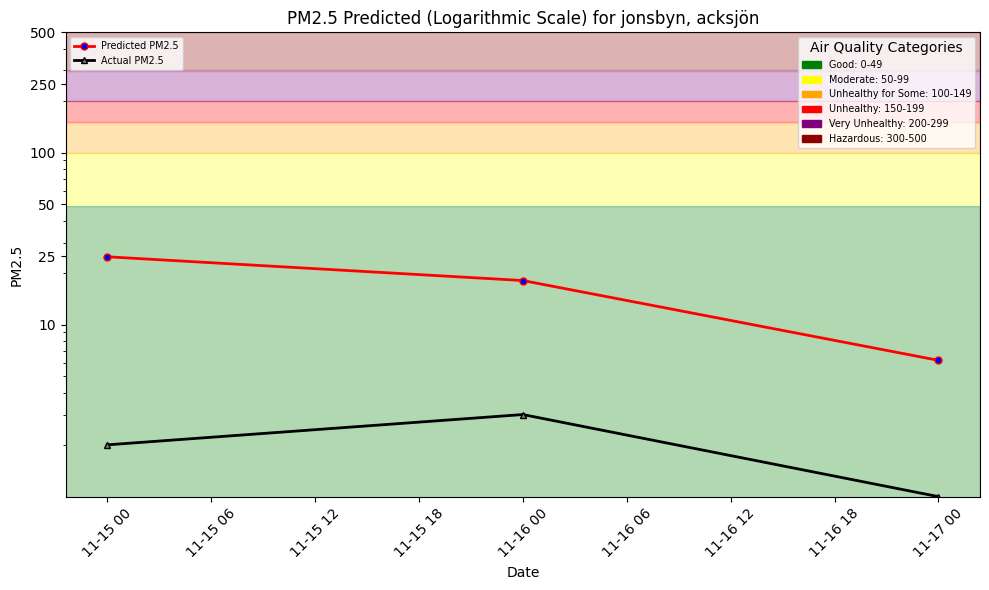

Uploading: 0.000%|          | 0/56440 elapsed<00:00 remaining<?

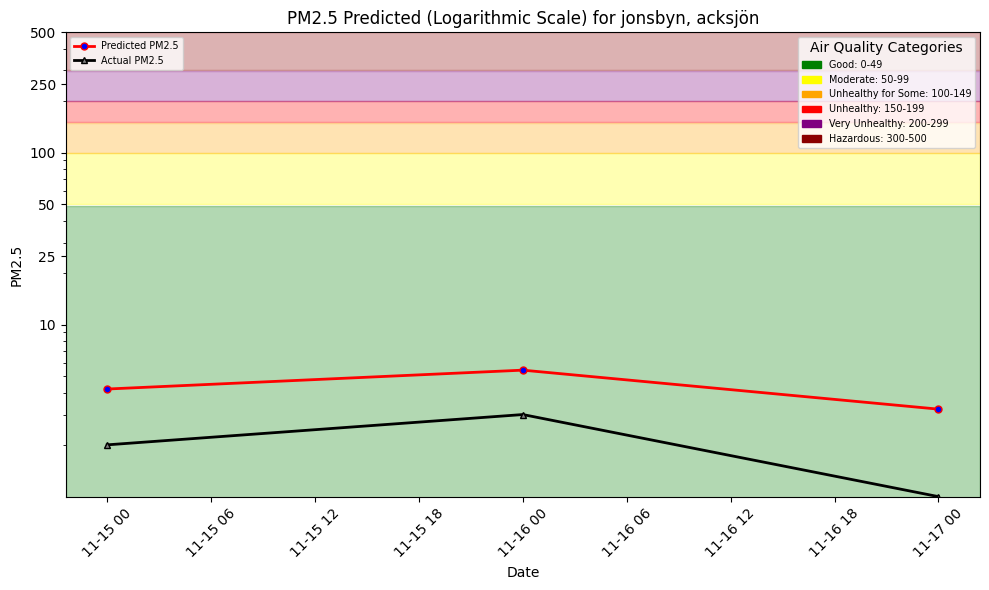

Uploading: 0.000%|          | 0/53445 elapsed<00:00 remaining<?

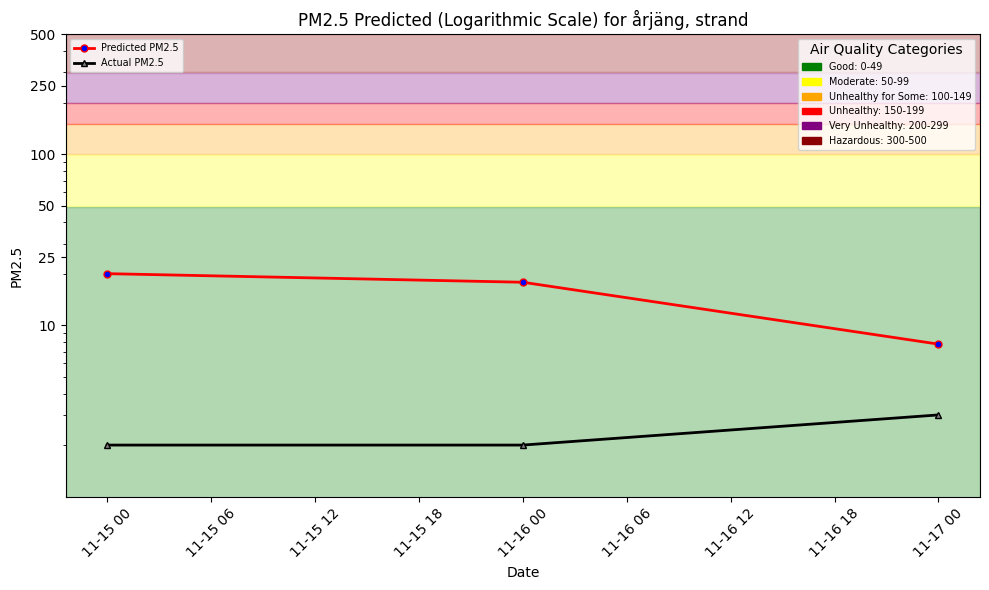

Uploading: 0.000%|          | 0/49354 elapsed<00:00 remaining<?

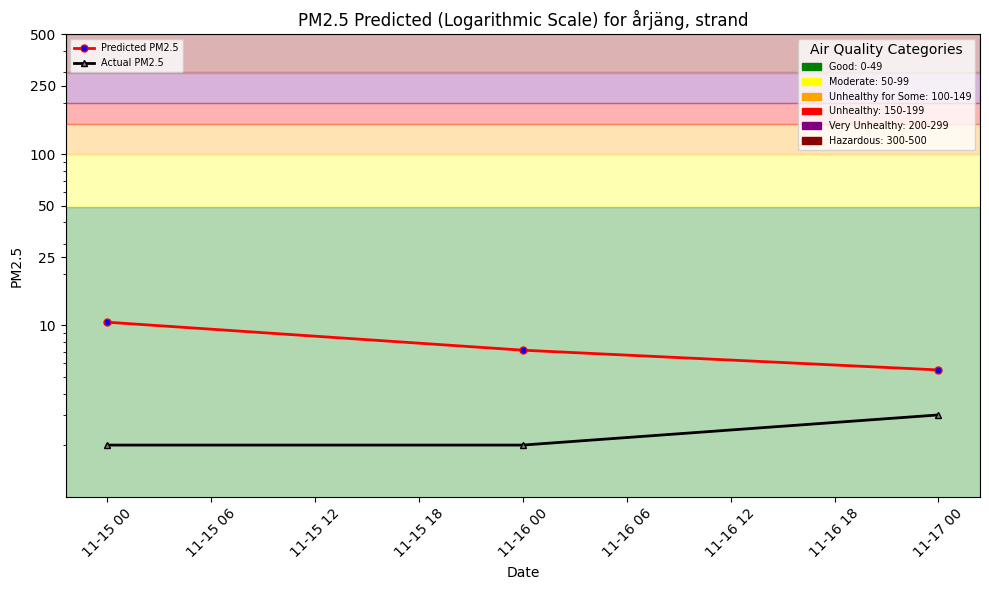

Uploading: 0.000%|          | 0/48399 elapsed<00:00 remaining<?

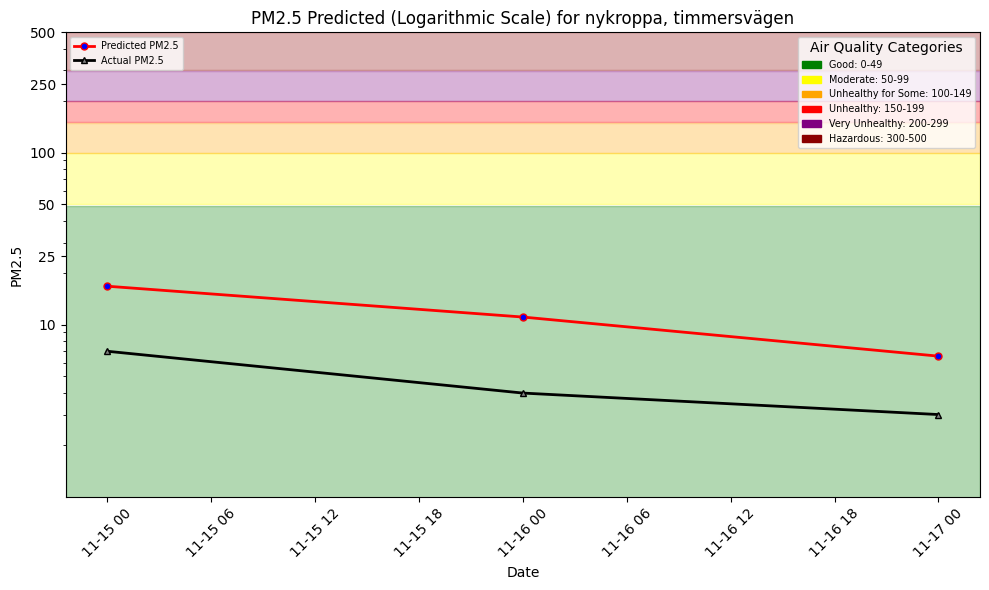

Uploading: 0.000%|          | 0/52911 elapsed<00:00 remaining<?

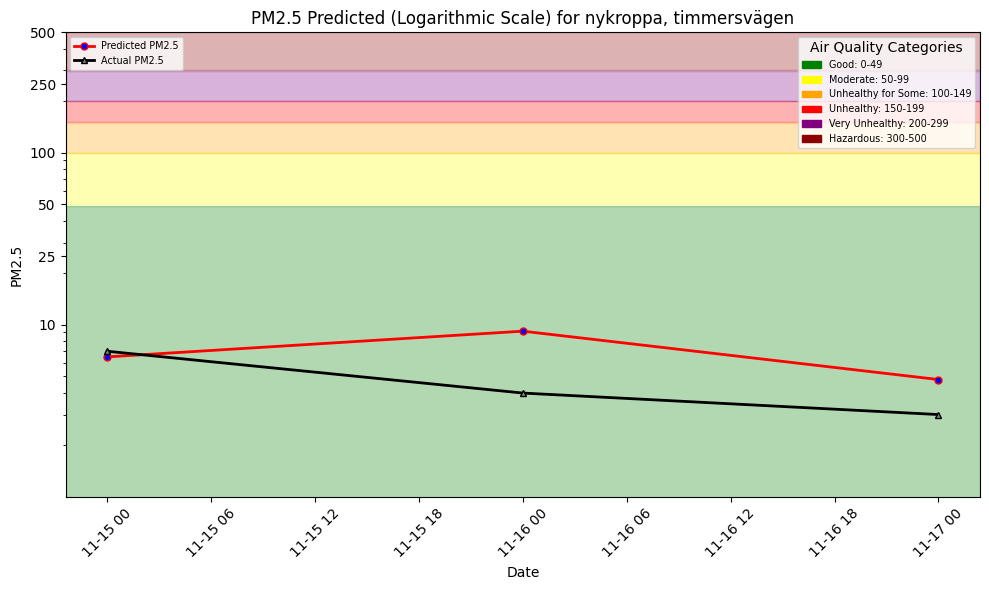

Uploading: 0.000%|          | 0/53169 elapsed<00:00 remaining<?

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272018/settings/fb/path/Resources/airquality


In [19]:
preds = {}
hindcast = {}

for model in models:
    preds[model] = monitoring[model][['date', 'predicted_pm25', 'city']]
    hindcast[model] = pd.merge(preds[model], air_quality_df, on=['date', 'city'])
    hindcast[model] = hindcast[model].sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
for location in sensors_data:
    city = location['city']
    street = location['street']
    hindcast_location = {}
    city_dir = {}
    hindcast_path = {}
    plots = {}
    for model in models:
        hindcast_location[model] = hindcast[model][hindcast[model]['city'] == city]
        city_dir[model] = f"{images_dir[model]}/{city}"
        hindcast_path[model] = f"{city_dir[model]}/pm25_hindcast.png"
        plots[model] = util.plot_air_quality_forecast(city, street, hindcast_location[model], hindcast_path[model], hindcast=True)
        plots[model].show()
        dataset_api.upload(hindcast_path[model], f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")